Preliminaries: importing the libraries.

In [1]:
import sys, os
sys.path.append("../..")
sys.path.append("..")
sys.path.append(os.getcwd())
import numpy as np
import pandas as pd
import copy
from dgp import *
np.set_printoptions(suppress=True)
from sklearn import linear_model
import plotnine as p9
import os
from plotnine import *
from glob import glob
from pathlib import Path
# from dgp import *
palette = ['#D55E00', '#E69F00', '#0072B2',
                  '#009E73', '#F0E442', '#CC79A7', '#56B4E9']

Reading in the data and converting it into a usable form

In [2]:
filename ='../dat/prop99.csv'

df = pd.read_csv(filename)
reader = df
df = df[df['SubMeasureDesc'] == 'Cigarette Consumption (Pack Sales Per Capita)']
pivot = df.pivot_table(values='Data_Value', index='LocationDesc', columns=['Year'])
dfProp99 = pd.DataFrame(pivot.to_records())

allColumns = dfProp99.columns.values

In [3]:
states = list(np.unique(dfProp99['LocationDesc']))
years = np.delete(allColumns, [0])
caStateKey = 'California'
states.remove(caStateKey)

yearStart = 1970
yearTrainEnd = 1989
yearTestEnd = 2000


In [4]:
discard1 = ['Massachusetts', 'Arizona', 'Oregon', 'Florida']
discard2 = ['Alaska', 'Hawaii', 'Maryland', 'Michigan','New Jersey', 'New York', 'Washington']
abadie = ['Colorado', 'Connecticut','Montana', 'Nevada','Utah']

In [5]:
discard = np.concatenate([discard1, discard2])
states = np.array(states)
mask = np.isin(states, discard)
states_clean = np.ma.masked_array(states, mask).compressed()
otherStates = states_clean

In [6]:
otherStates

array(['Alabama', 'Arkansas', 'Colorado', 'Connecticut', 'Delaware',
       'District of Columbia', 'Georgia', 'Idaho', 'Illinois', 'Indiana',
       'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Minnesota',
       'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada',
       'New Hampshire', 'New Mexico', 'North Carolina', 'North Dakota',
       'Ohio', 'Oklahoma', 'Pennsylvania', 'Rhode Island',
       'South Carolina', 'South Dakota', 'Tennessee', 'Texas', 'Utah',
       'Vermont', 'Virginia', 'West Virginia', 'Wisconsin', 'Wyoming'],
      dtype='<U20')

Now we prep the data and split it into training and test sets.

In [7]:
trainingYears = []
for i in range(yearStart, yearTrainEnd, 1):
    trainingYears.append(str(i))

testYears = []
for i in range(yearTrainEnd, yearTestEnd, 1):
    testYears.append(str(i))

trainDataDict = {}
testDataDict = {}
for key in otherStates:
    series = dfProp99.loc[dfProp99['LocationDesc'] == key]
    trainDataDict.update({key: series[trainingYears].values[0]})
    testDataDict.update({key: series[testYears].values[0]})
series = dfProp99[dfProp99['LocationDesc'] == caStateKey]
trainDataDict.update({caStateKey: series[trainingYears].values[0]})
testDataDict.update({caStateKey: series[testYears].values[0]})

trainDF = pd.DataFrame(data=trainDataDict)
testDF = pd.DataFrame(data=testDataDict)

In [50]:
table =['California', 'Alabama','Arkansas', 'Virginia','Wisconsin', 'Wyoming']
years = ['LocationDesc','1970', '1971', '1972', '1988', '1989']
tmp = dfProp99.loc[dfProp99['LocationDesc'].isin(table)]

In [51]:
tmp[years]

,LocationDesc,1970,1971,1972,1988,1989
0,Alabama,89.8,95.4,101.1,112.1,105.6
3,Arkansas,100.3,104.1,103.9,121.5,118.3
4,California,123.0,121.0,123.5,90.1,82.4
46,Virginia,124.3,128.4,137.0,129.5,122.5
49,Wisconsin,106.4,105.4,108.8,102.6,100.3
50,Wyoming,132.2,131.7,140.0,114.3,111.4


This is what the test and train matrices look like (in the library we represent each donor pool 
or intervention unit as a separate column, and each timepoint as a row)

In [9]:
def make_full(train, test, index):
    full = np.concatenate([train[index].values, test[index].values])
    return full

In [10]:
def make_prediction(index, convex=True, return_weight=False):
    full = make_full(trainDF, testDF, index)
    if convex:
        w = ConvexRegression(trainDF[index].values, trainDF['California'].values)
        #import ipdb; ipdb.set_trace()
        res = full@w.x
        coef = w.x
    else:
        reg = linear_model.LinearRegression(fit_intercept=False)
        reg.fit(trainDF[index].values, trainDF['California'].values)
        res = reg.predict(full)
        coef = res.coef_
    if return_weight==True:
        return (res, coef)
    else:
        return res

In [11]:
R1= {'Connecticut':3287116, 'Maine':1227928, 'New Hampshire':1109252, 'Rhode Island':1003464, 'Vermont':562758}
R2 = { 'Pennsylvania':11881643}
R3= {'Illinois':11430602, 'Indiana':5544159, 'Ohio':10847115, 'Wisconsin':4891769}
R4 = {'Iowa':2776755, 'Kansas':2477574, 'Minnesota':4375099, 'Missouri':5117073, 'Nebraska':1578385, 'North Dakota':638800, 'South Dakota':696004}
R5 = {'Delaware': 71830, 'Georgia':6478216,'North Carolina':6628637, 'South Carolina':3486703, 'Virginia':6187358, 'District of Columbia':606900, 'West Virginia':1793477}
R6={'Alabama':4040587, 'Kentucky':3685296, 'Mississippi':2573216,  'Tennessee':4877185}
R7 = {'Arkansas':2350725, 'Louisiana':4219973, 'Oklahoma':3145585, 'Texas':16986510}
R8 = {'Colorado':3294394, 'Idaho':1006749, 'Montana':799065, 'Nevada':1201833,'New Mexico':1515069, 'Utah':1722850, 'Wyoming':453588}


In [12]:
3294394 + 1006749 + 799065 + 1201833 + 1515069 + 1722850 + 453588

9993548

In [13]:
def make_regions(Rs, trainDF, testDF, names):
    for i in range(len(Rs)):
        factor = 1.0/sum(Rs[i].values())
        res = {k: v*factor for k, v in Rs[i].items()}
        trainDF[names[i]]= np.sum(trainDF[res.keys()]*res.values(),1)
        testDF[names[i]]= np.sum(testDF[res.keys()]*res.values(),1)
    return trainDF, testDF

In [14]:
Rs = [R1, R2,R3,R4,R5,R6,R7,R8]
regions = ['New_England','Mid_Atlantic','East_North_Central','West_North_Central',
         'South_Atlantic','East_South_Central','West_South_Central','Mountain']

trainDF, testDF = make_regions(Rs, trainDF, testDF, regions)

In [15]:
years = np.concatenate([trainingYears, testYears])

In [16]:
pred1, weight1 = make_prediction(abadie, return_weight=True)
pred2, weight2 = make_prediction(regions, return_weight=True)
years = np.concatenate([trainingYears, testYears])
names=['Synthetic California (Abadie 2010)', 'Synthetic California (Divisional Units)', 'Observed California']
d1 = {"year": years,
     "pred": pred1,
     "group": [names[0]]*len(pred1),
      'observed':['0']*len(pred1)
     }

d2 = {"year": years,
     "pred": pred2,
     "group": [names[1]]*len(pred1),
    "observed":['0']*len(pred1)
     }
actual = np.concatenate([trainDF['California'].values, testDF['California'].values])
d3 = {"year": years,
     "pred": actual,
     "group": [names[2]]*len(pred1),
     "observed":['1']*len(pred1)}

d4 = {"year": testYears,
     "pred": testDF['California'].values,
     "group": names[2]*len(pred1)
     }

#actual = np.concatenate([trainDF['California'].values, testDF['California'].values])

In [17]:
Data = pd.concat([pd.DataFrame(d1), pd.DataFrame(d2), pd.DataFrame(d3)])

In [18]:
breaks = []
breaks.append(years[0])
breaks.append(years[-1])
for i in range(30):
    if i %5 == 0:
        breaks.append(years[i])
breaks.append('1988')

/Users/claudiashi/miniforge3/envs/pytorch_x86/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 9 x 6 in image.
/Users/claudiashi/miniforge3/envs/pytorch_x86/lib/python3.8/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: ../fig/regions.pdf


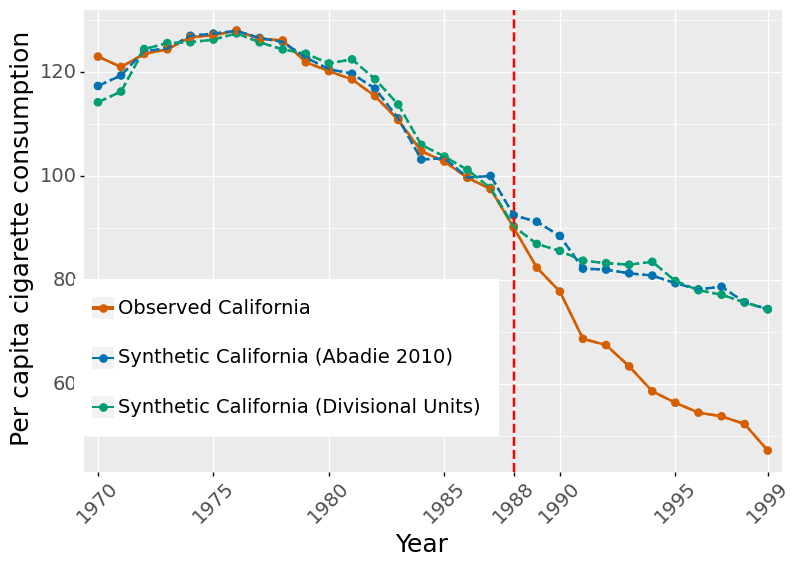

In [19]:
p = ggplot(Data,aes(x='year',y='pred',group='group',colour='group', linetype='group')) + \
        geom_line(aes(group='group'),size=1) + \
        geom_point(size=2.5) + \
        labs(x=r'Year',y=r'Per capita cigarette consumption') +\
        theme(figure_size=(9,6),\
            legend_position=(0.35, 0.3),\
#               subplots_adjust={'right': 0.8},\
            text = element_text(size=14), \
            title=element_text(size=18),\
                legend_title = element_blank(),\
                    legend_entry_spacing_y = 20,\
               axis_text_x=element_text(rotation=45),
            ) +\
            scale_x_discrete(breaks=breaks)+\
        scale_color_manual({names[0]:palette[2],
                            names[1]:palette[3],
                            names[2]:palette[0]
                           }) +\
            scale_linetype_manual(values=['solid', 'dotted', 'dotted'])

p += geom_vline(xintercept=19,linetype='dashed',size=1, color='red')
p += geom_line(aes(group='group'),size=1, linetype = "dashed")
ggplot.draw(p)
ggplot.save(p, filename='../fig/regions.pdf')